# `Inside the Offshores leak`
`Panama Papers as you have never seen it`
***


# Research Question 4
> ##### There is a hypothesis that scandals involving tax havens actually help to promote creating offshores there. 
See for example [International Strategic Analysis](http://www.isa-world.com/news/?tx_ttnews%5BbackPid%5D=1&tx_ttnews%5Btt_news%5D=198&cHash=10b412a7de63d3b2a02adf0d120a09f6). Can we find evidence for this in the data?

## Most important leaks
Here is a list of the most important leaks documented by the International Consortium of Investigative Journalists [ICIJ](https://offshoreleaks.icij.org/)
- ##### Bahamas Leak 
April 2, 2013
None got scared [Best year =  2010]
- ##### China Leak ⭐️
January 21, 2014
More offshores [Seyschelles - Samoa - British Virgin Islands - British Anguila] 
- ##### Lux Leak 
December 9, 2014
None got scared [Best year =  2007]
- ##### Swiss Leak 
February 8, 2015 
None got scared [Best year =  2007]
- ##### Panama Leak
April 3, 2016 

### Importing libs
___

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
%matplotlib inline
from bs4 import BeautifulSoup
import folium
import json
import dateutil.parser
import datetime as dt
from datetime import datetime
from scipy.interpolate import interp1d

### Loading csv files

In [2]:
entities = r'./panama_csv/Entities.csv'
entities = pd.read_csv(entities,index_col='name', header=0, low_memory=False)
entities=entities.rename(columns = {'countries':'Country'})

### Parsing dates function
In this function we parse all the dates in a standard format using **dateutil library**

In [3]:
def is_date_before(date_, div_date):
    return date_ <= div_date

def categorize_leak(row, event, delimiter, lower_date, upper_date):
    if isinstance(row[event], pd.Timestamp): 
        date = row[event].to_pydatetime()
    else:
        return np.nan
    if(is_date_before(date, lower_date)):
        return np.nan
    elif(is_date_before(upper_date, date)):
        return np.nan
    elif(is_date_before(date, delimiter)):
        return True
    else:
        return False

def parse_year_of_date(row, column, from_year, to_year):
    if isinstance(row[column], str):
        date = dateutil.parser.parse(row[column])
        if date.year <= to_year and date.year >= from_year:
            return date.year #.strftime('%Y-%m')
        else:
            return np.nan
    else:
        return np.nan    
    
def parse_dates(dataframe, from_year, to_year): #leak_data, bounded_data_bottom, bounded_data_up
    date_events = [["incorporation_date","incorporation_before_leak"],
                   ["inactivation_date","inactivation_before_leak"], 
                   ["struck_off_date","struck_off_before_leak"],
                   ["dorm_date", "dorm_date_before_leak"]]
    for date_event in date_events:
        dataframe[date_event[0]] = dataframe.apply(lambda row: parse_year_of_date(row,date_event[0], from_year, to_year), axis=1) 
    return dataframe

### Create plot visualization
___

In [4]:
#Import new style
plt.style.use('bmh')

In [5]:
def visualize_countries_situation(most_involved_leak, divide_by='Country'):
    for index_, country_result in enumerate(most_involved_leak):     
        sns.factorplot(x='date', 
                   y='offshores', 
                   row=divide_by, 
                   data=country_result, 
                   hue='action',
                   kind='bar', 
                   palette={'incorporations':'green','inactivations':'red','strucks':'black', 'active offshores':'blue'},
                   sharey=False, 
                   sharex=False,
                   size=4,
                   aspect=4)

### Process Entities dataframe
___

In [6]:
def process_countries(first_involved_countries, analisys_on='jurisdiction', from_year=1990, to_year=2017):
    most_involved_leak = []
    for index, involved_country in enumerate(first_involved_countries):
        testing_entities = entities.copy()
        involved_leak = testing_entities[testing_entities['Country'].isin([involved_country])].copy()
        involved_leak = parse_dates(involved_leak, from_year, to_year)
        total_incorporation = involved_leak.groupby(['Country','jurisdiction_description', 'incorporation_date']).count()
        total_inactivation = involved_leak.groupby(['Country','jurisdiction_description', 'inactivation_date']).count()
        total_struck = involved_leak.groupby(['Country','jurisdiction_description', 'struck_off_date']).count()
        incorporation = total_incorporation.reset_index().rename(columns={'incorporation_date': 'date', 'node_id': 'incorporations'}).set_index(['Country','jurisdiction_description','date'])
        inactivation = total_inactivation.reset_index().rename(columns={'inactivation_date': 'date', 'node_id': 'inactivations'}).set_index(['Country','jurisdiction_description','date'])
        struck = total_struck.reset_index().rename(columns={'struck_off_date': 'date', 'node_id': 'strucks'}).set_index(['Country','jurisdiction_description','date'])
        incorporation = incorporation.loc[:, ['incorporations']]
        inactivation = inactivation.loc[:, ['inactivations']]
        struck = struck.loc[:, ['strucks']]
        country_res = pd.merge(incorporation.reset_index(),
                                           inactivation.reset_index(), 
                                           on=['Country','jurisdiction_description', 'date'],
                                           how='outer').set_index(['Country','jurisdiction_description','date'])
        country_res = pd.merge(country_res.reset_index(),
                                           struck.reset_index(), 
                                           on=['Country','jurisdiction_description', 'date'],
                                           how='outer').set_index(['Country','jurisdiction_description','date'])
        involved = involved_leak.copy()
        for index, row in country_res.iterrows():
            number_of_offshores = involved[
                ((involved['inactivation_date'] > int(index[2])) | 
                (pd.isnull(involved['inactivation_date']))) &
                (involved['incorporation_date'] <= int(index[2])) & 
                (involved['Country'] == index[0]) &
                (involved['jurisdiction_description'] == index[1])].count()['node_id'] 
            country_res.loc[index, 'active offshores'] = number_of_offshores 
        country_result = country_res.loc[:, ['incorporations','inactivations','active offshores','strucks']]
        country_result = country_result.reset_index()
        country_result = country_result.set_index(['Country','jurisdiction_description','date'])
        country_result = pd.DataFrame(country_result.stack())
        country_result = country_result.reset_index()
        country_result = country_result.rename(columns={'level_3': 'action', 0: 'offshores', 'jurisdiction_description':'jurisdiction'})
        country_result["date"] = country_result["date"].astype(int)
        most_involved_leak.append(country_result.set_index(analisys_on))
    return most_involved_leak

### Analysis on jurisdictions and the most involved countries
___

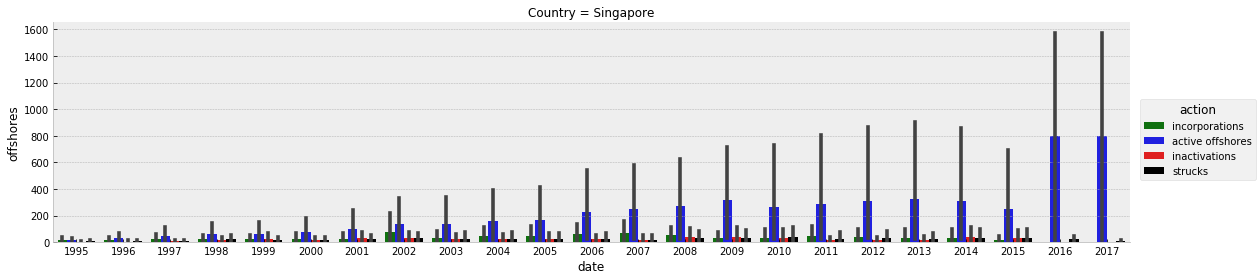

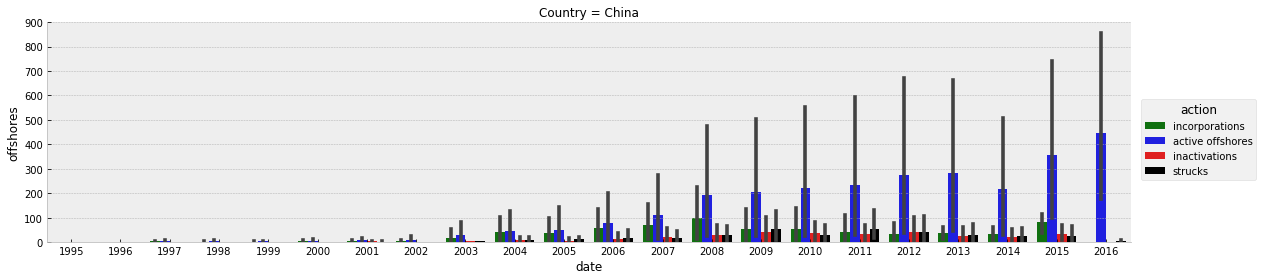

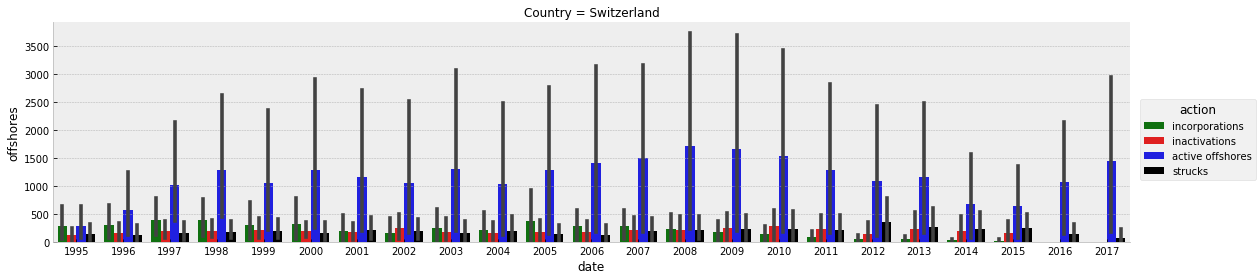

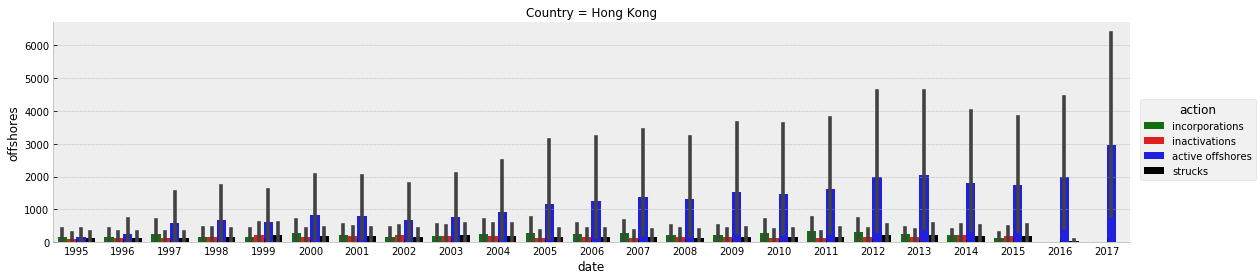

In [19]:
most_involved_countries = ['Switzerland', 'Hong Kong', 'Panama', 'Jersey', 'Luxembourg', 'United Kingdom',
                          'Guernsey', 'United Arab Emirates', 'Bahamas', 'Uruguay','Isle of Man', 'Russia',
                          'Singapore', 'China','United States','Monaco', 'Italy']

first_involved_countries = [
                            'Singapore',
                            'China',
                            'àSwitzerland', 
                            'Hong Kong', 
                            #'Panama', 
                            #'Luxembourg', 
                            #'Bahamas',
                           ]
countries_frame = process_countries(first_involved_countries, analisys_on='jurisdiction', from_year=1995, to_year=2017)
visualize_countries_situation(countries_frame, divide_by='Country')
# export_csv(countries_frame)

### Analysis on each Country over the jurisdictions
___

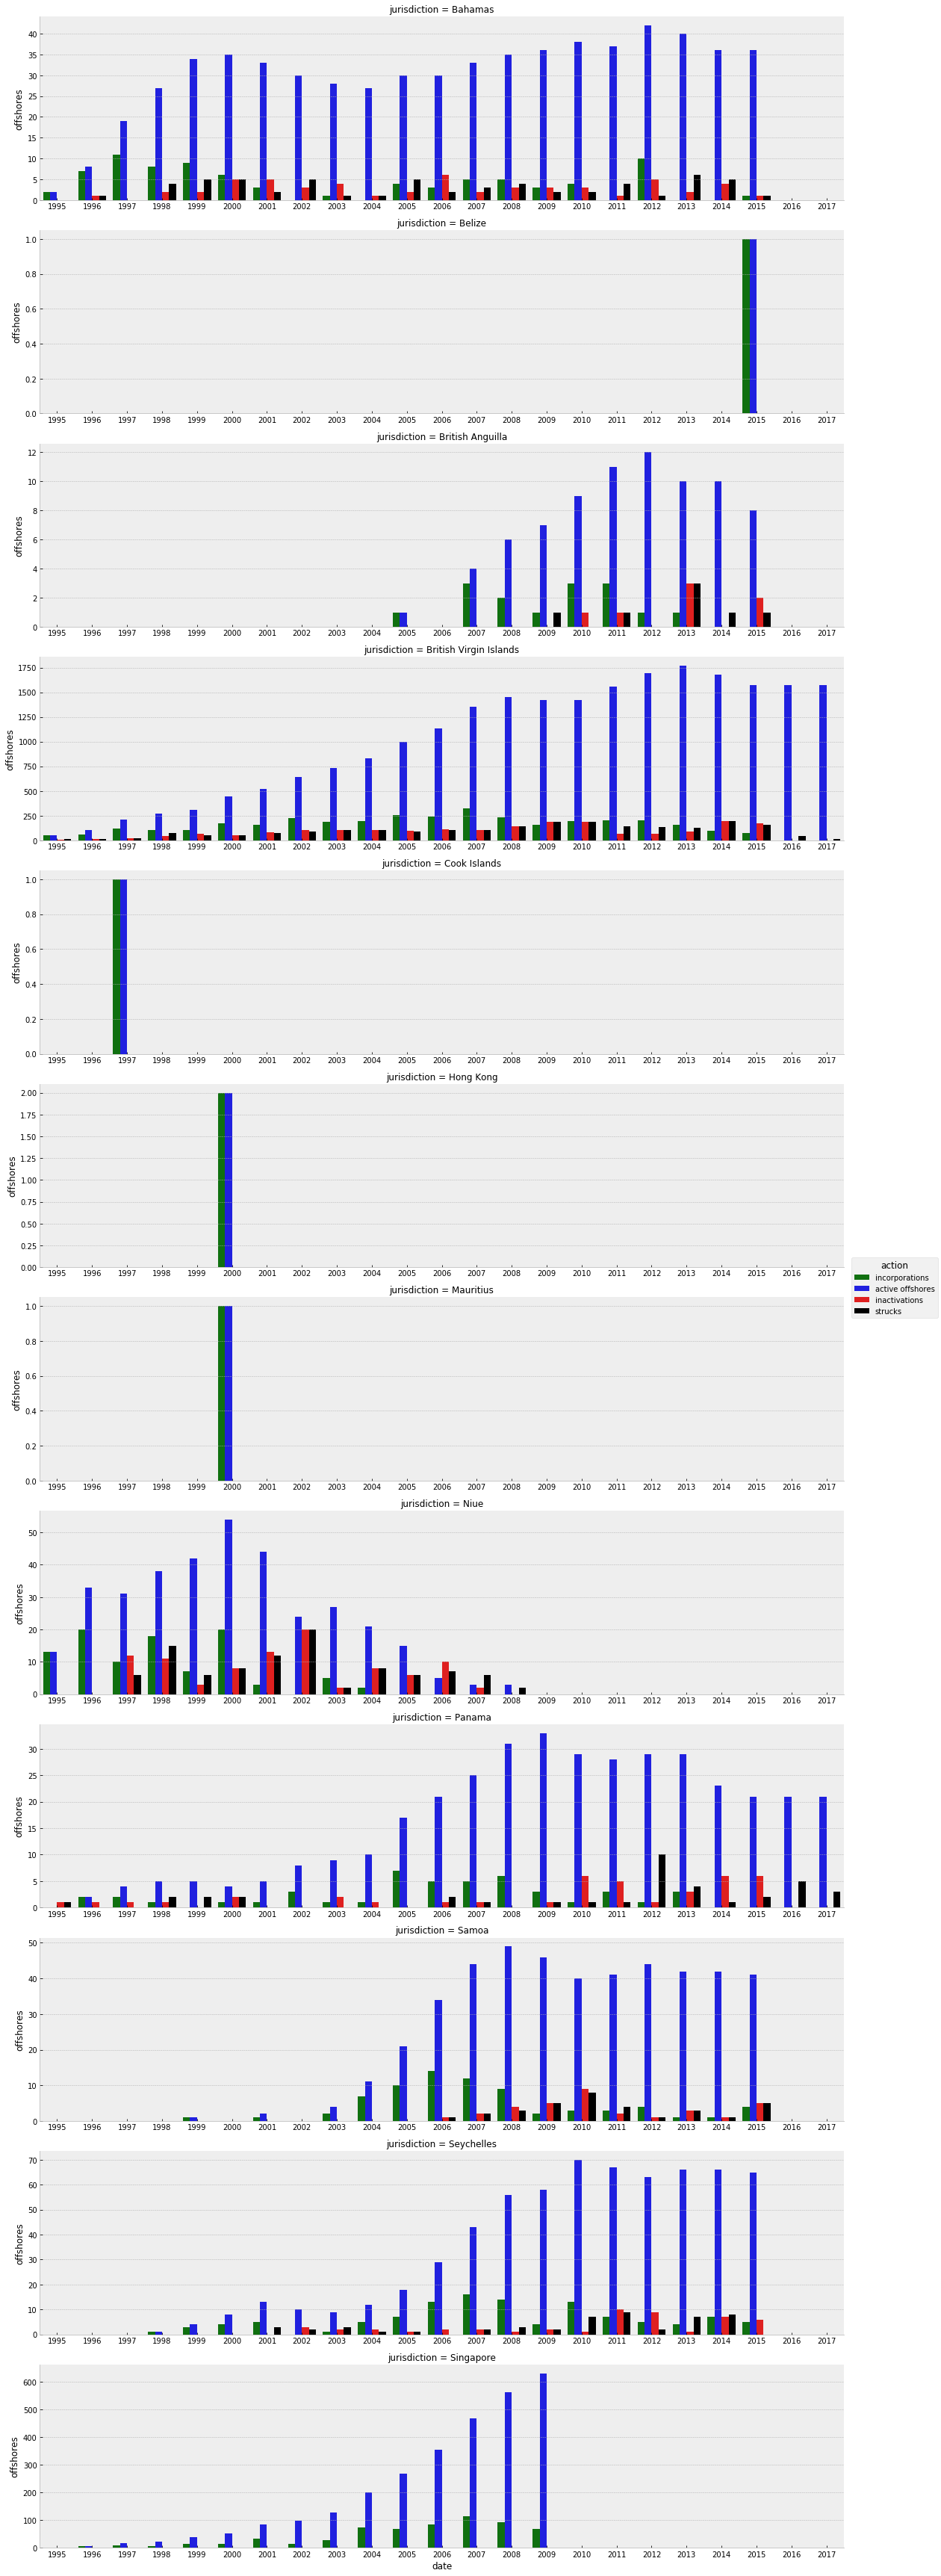

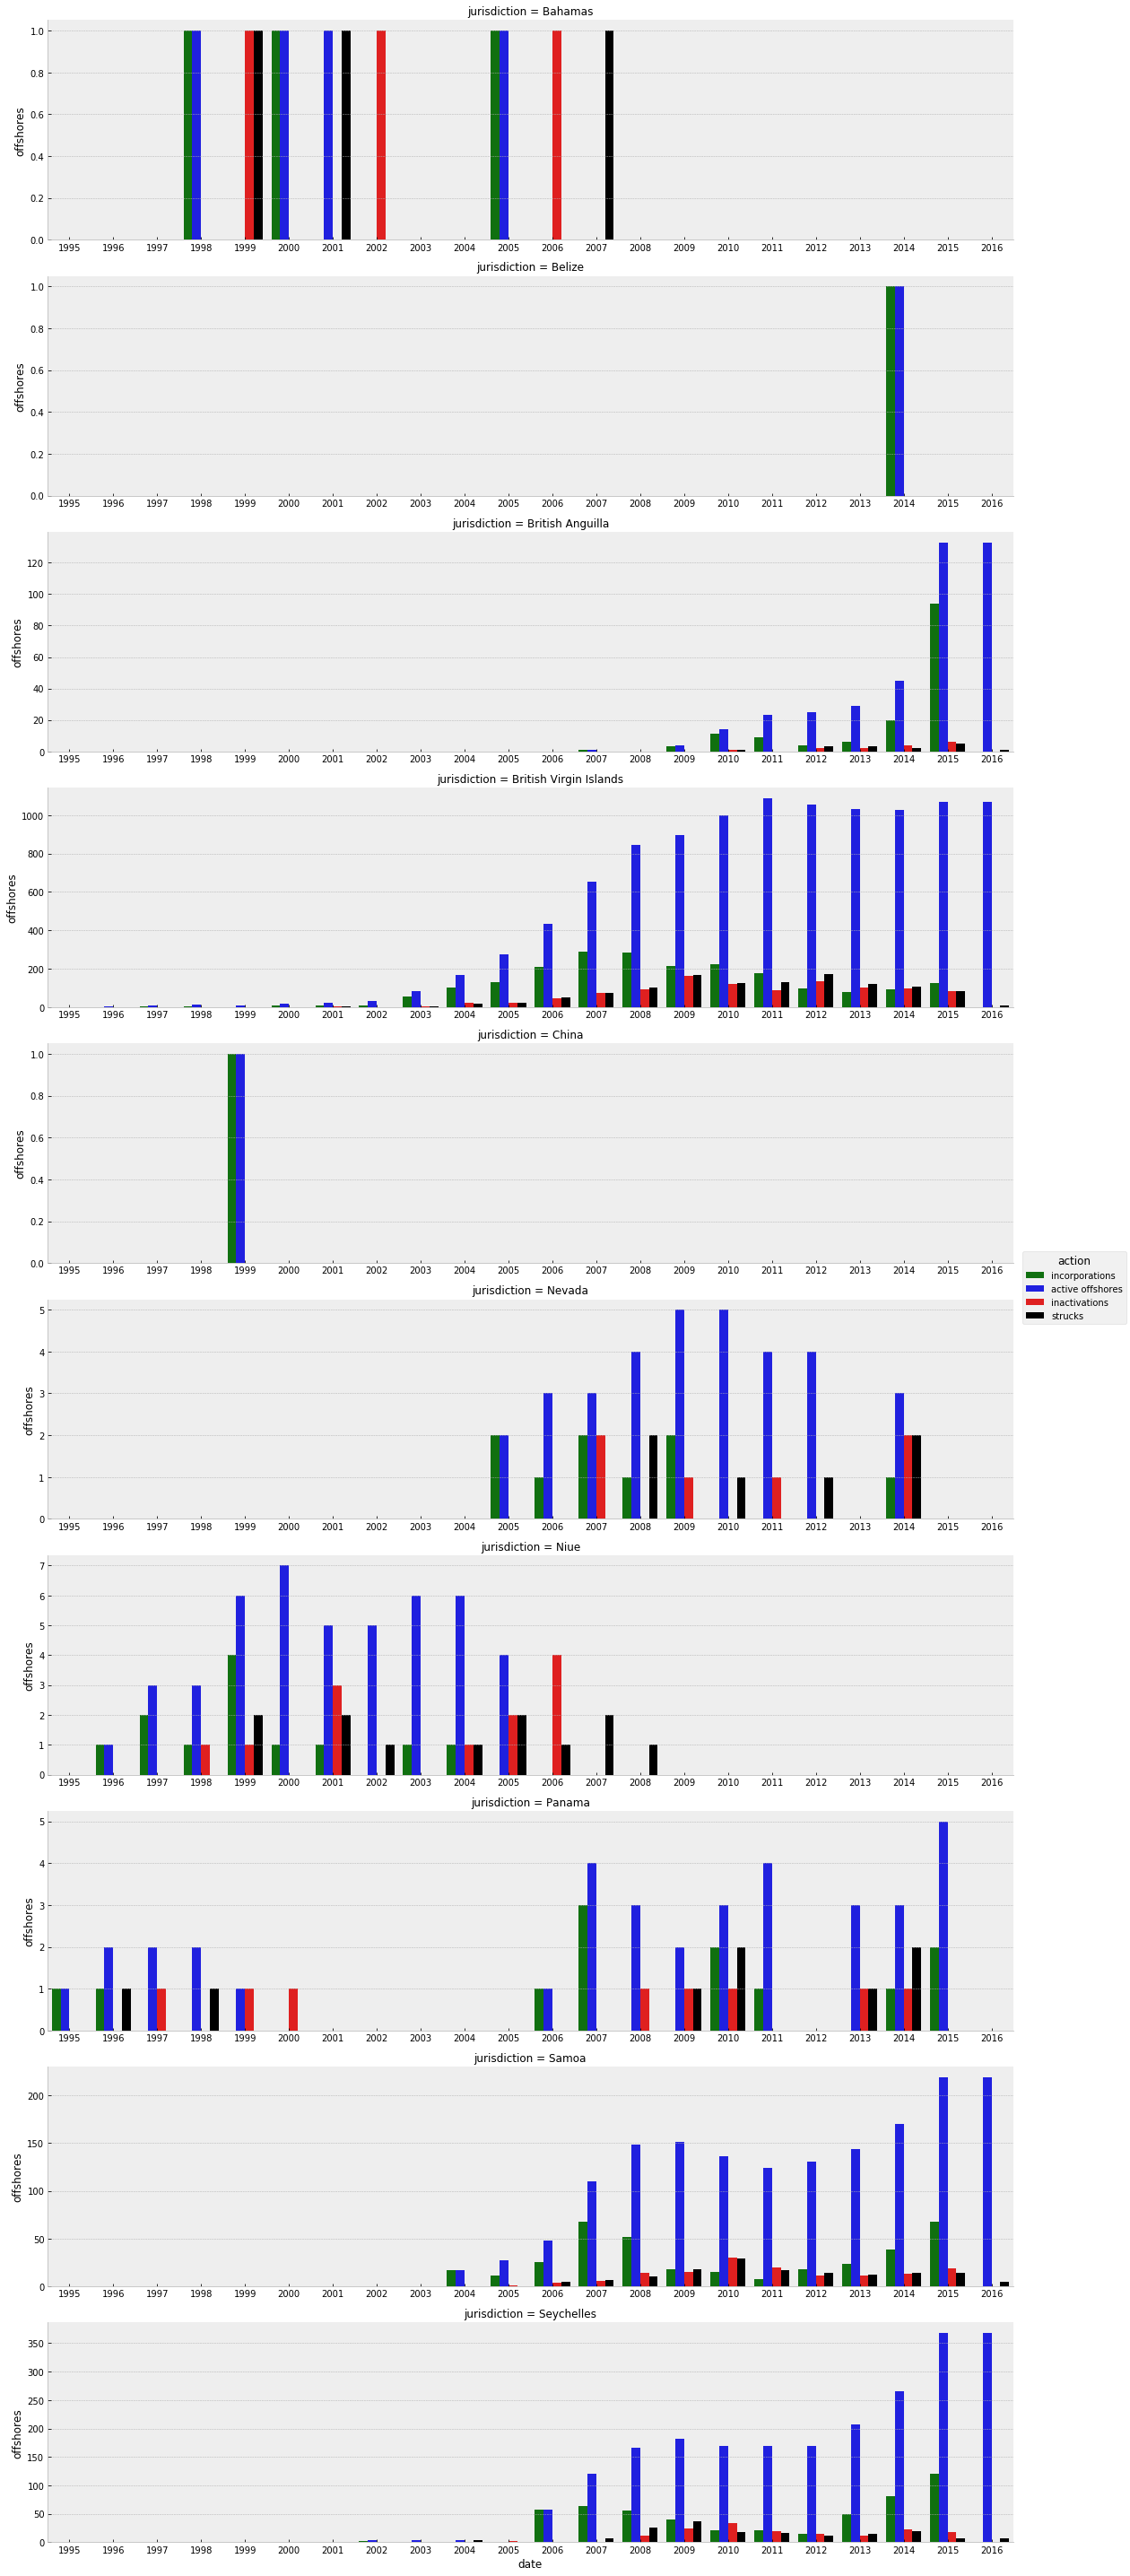

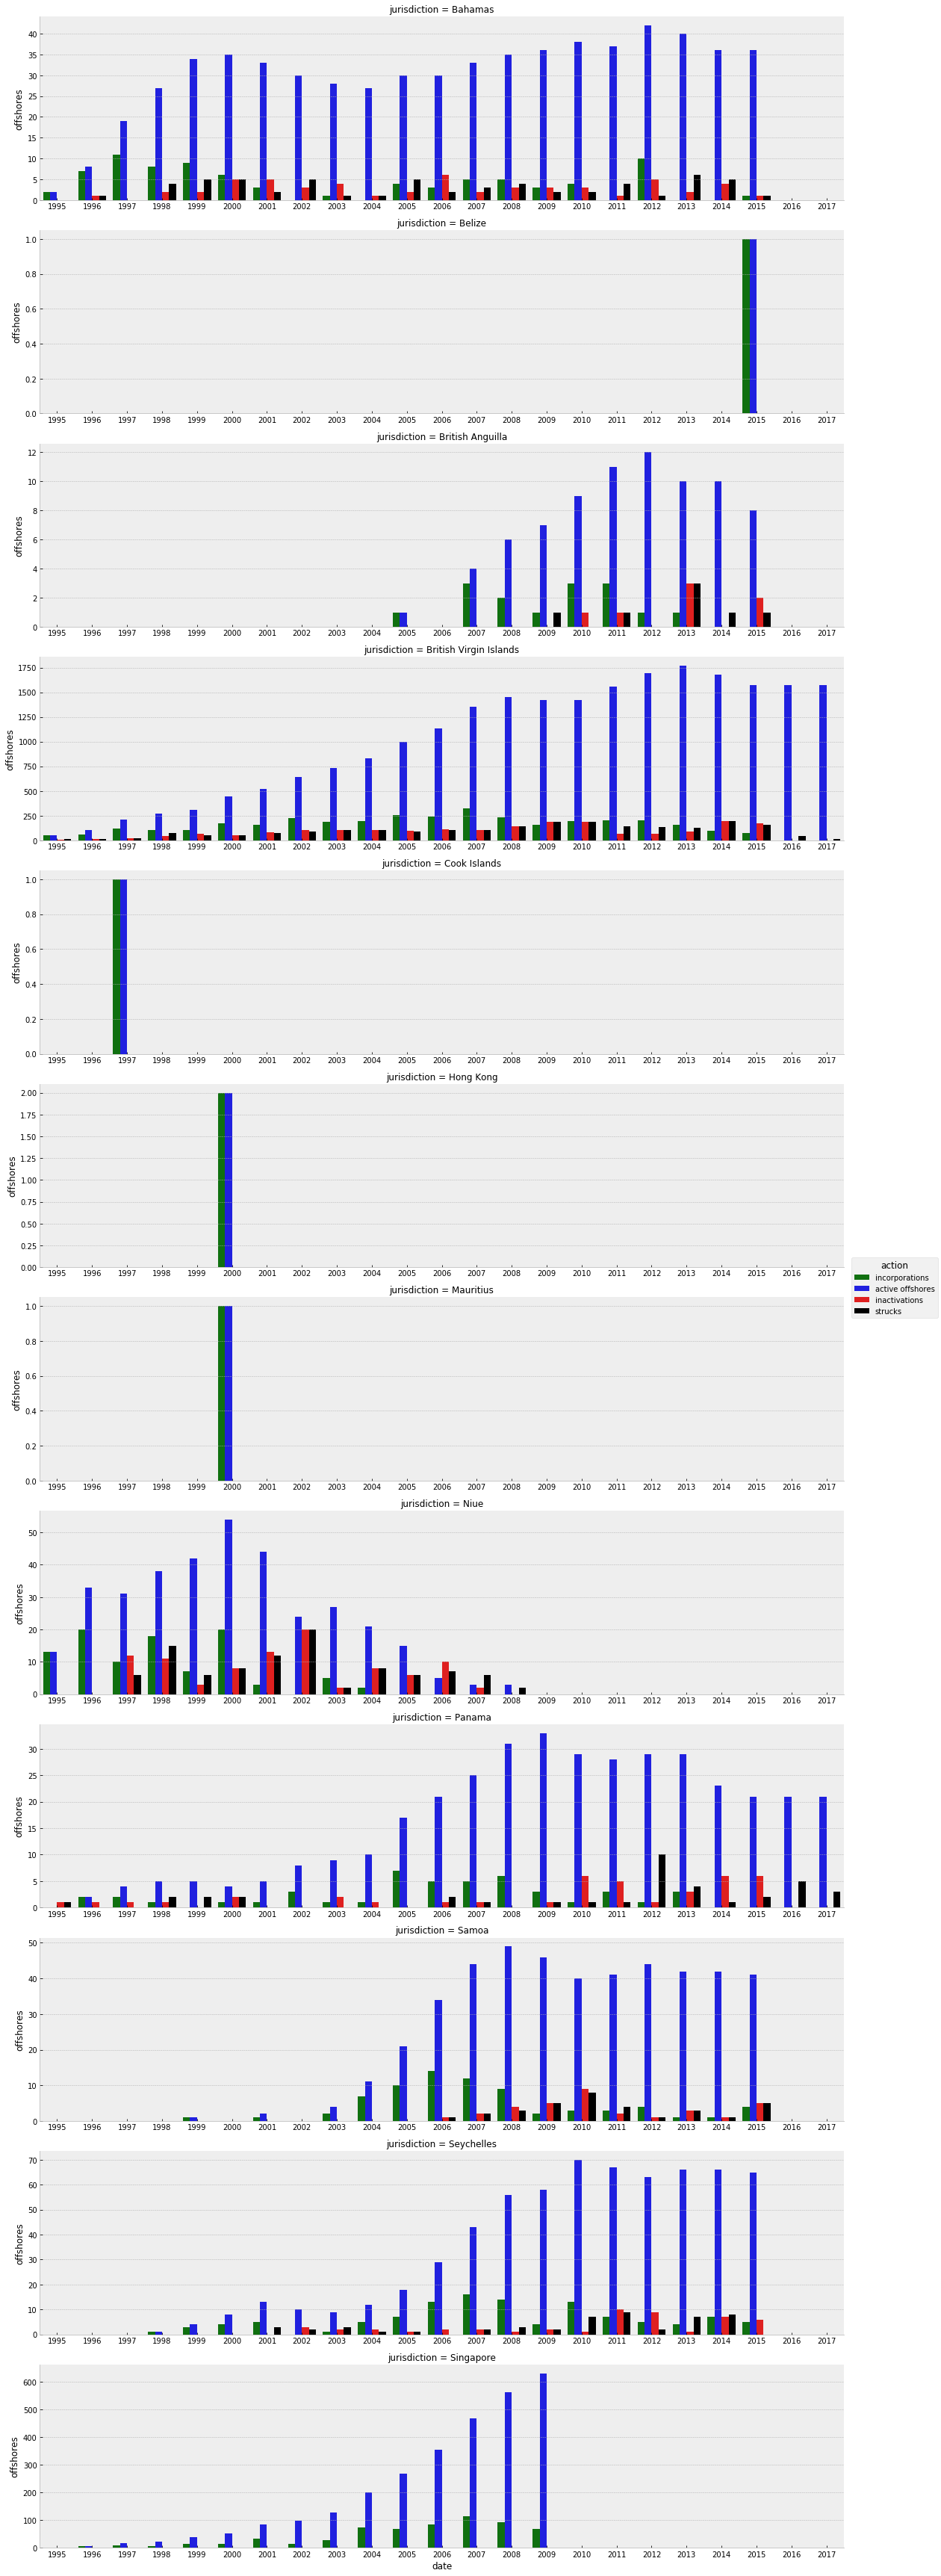

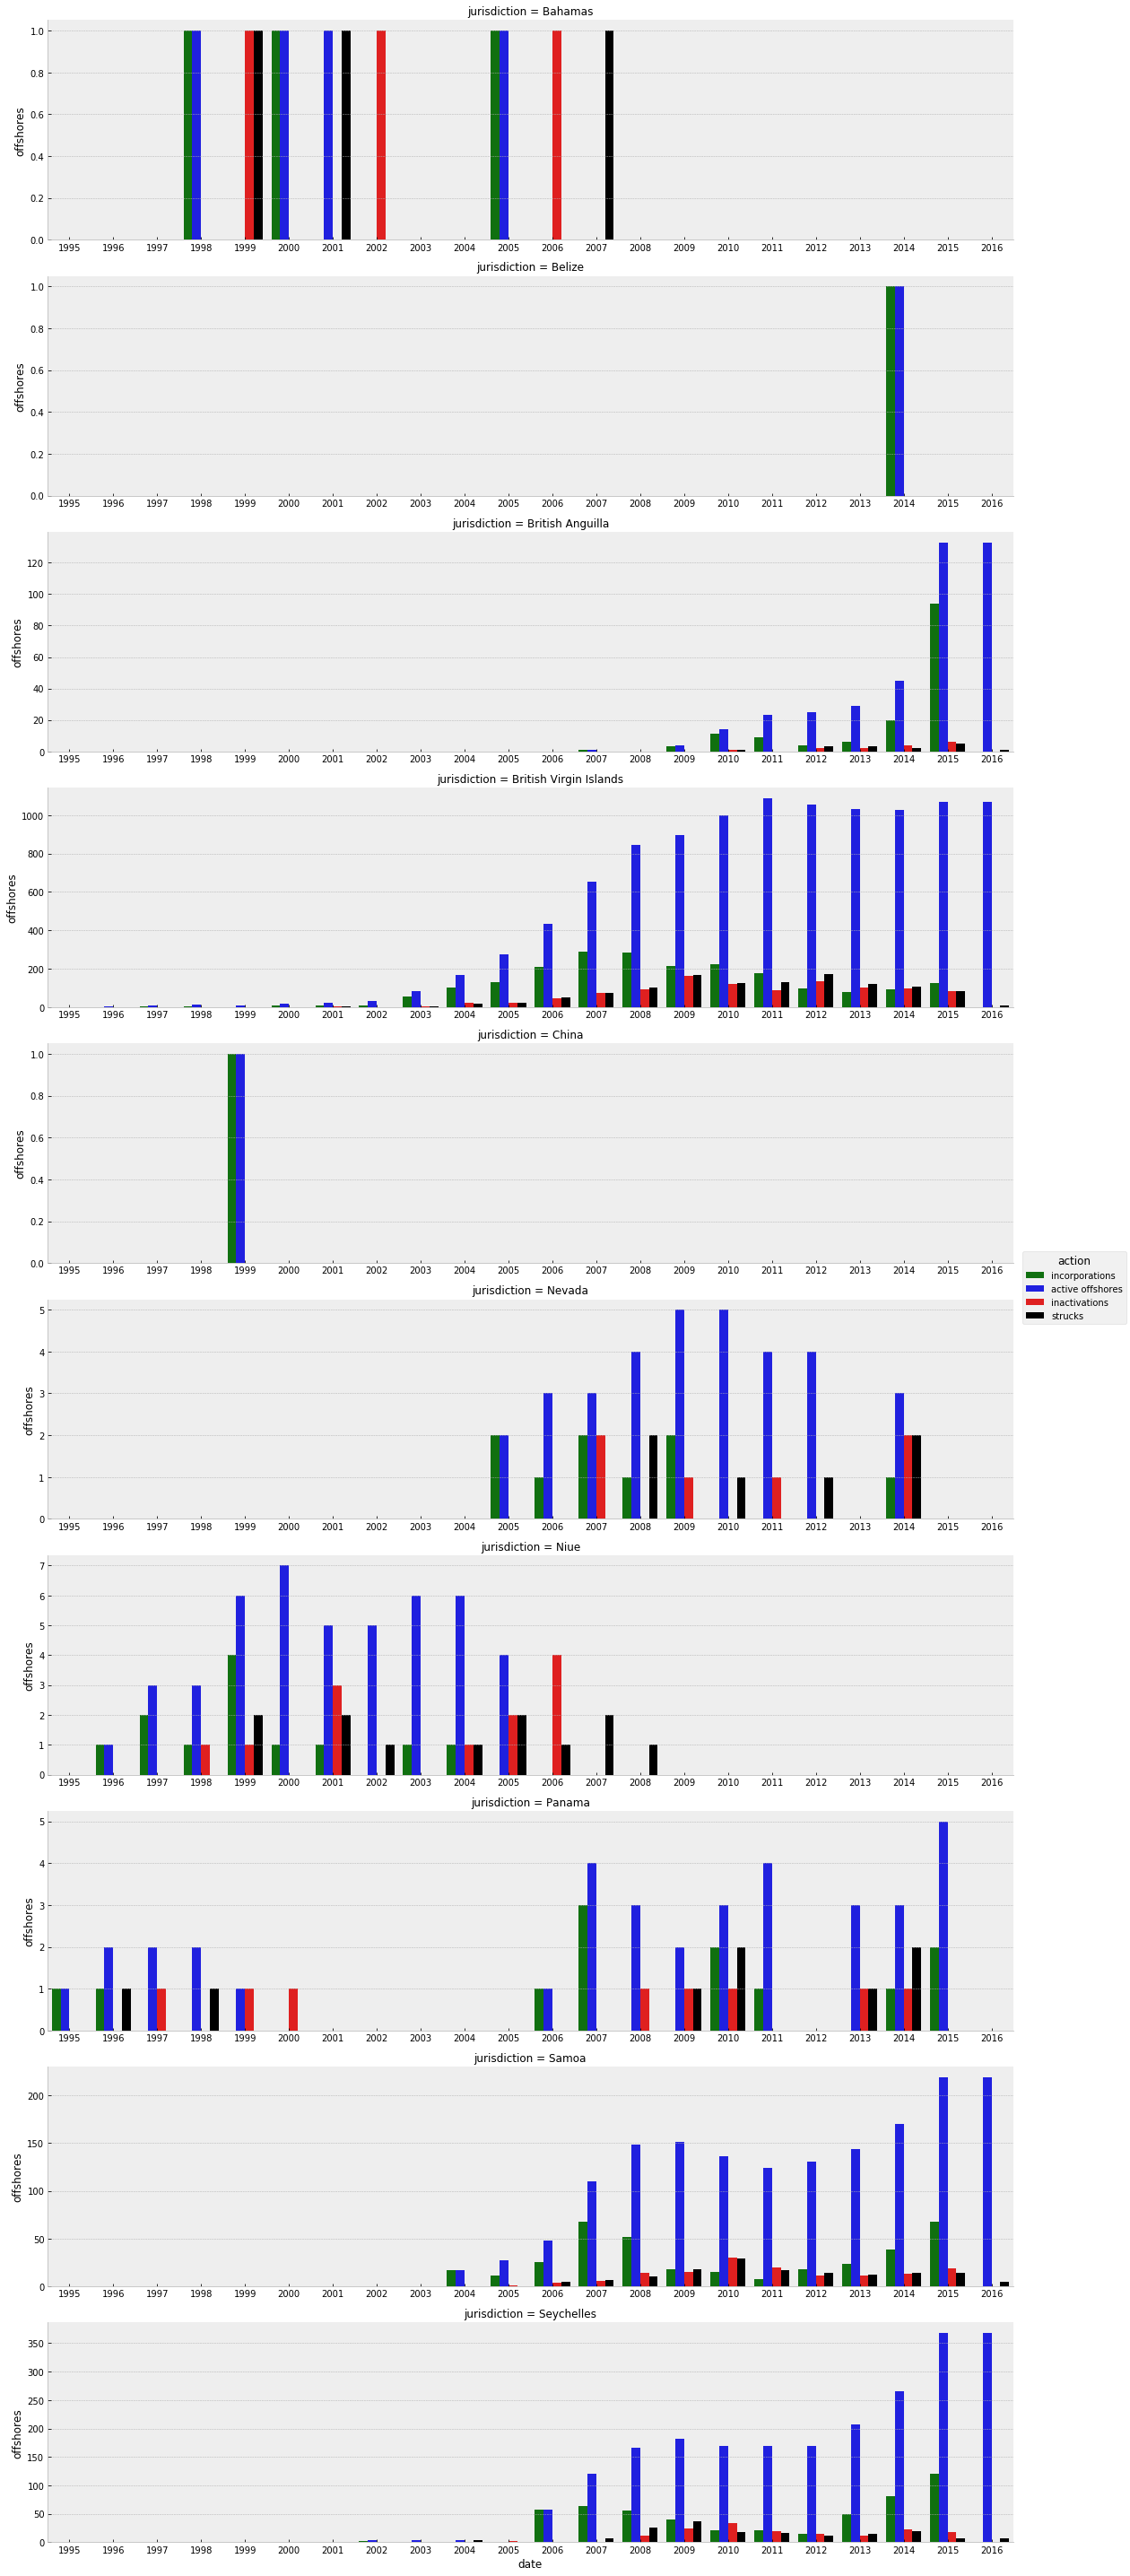

In [11]:
involved_countries = [
                            'Singapore',
                            'China',
                            #'Switzerland', 
                            #'Hong Kong', 
                            #'Panama', 
                            #'Luxembourg', 
                            #'Bahamas',
                           ]
countries_frame = process_countries(involved_countries, analisys_on='Country', from_year=1995, to_year=2017)
visualize_countries_situation(countries_frame, divide_by='jurisdiction')
plt.show()

### How much money do you need in order to make an offshore account worthwhile?

Just because offshore accounts can be lucrative for the rich doesn’t mean they would be beneficial to everyone. The majority of Canadians don’t even reach the maximum contribution levels for their Tax Free Savings Accounts. 

> You really have to have accumulated capital that you’re investing, so you’re earning investment income. Most middle-income people don’t have investment income.

Even a physician or lawyer making upwards of \$250,000 probably still isn’t earning enough for an offshore account to be worthwhile, he says, especially after accounting for the legal and accounting costs in Canada, plus paying the foreign jurisdictions to set up the account.

> It’s worth it if you’ve accumulated family wealth—in the \$5 million-plus range and you’re earning five per cent or more per year.

Which is exactly why he says people have the right to be angry about such offshore accounts. 

> It’s a two-tiered system, but it’s not transparent. We don’t say ‘If you have $5 million a year, your tax rate is lower than everyone else’s’. That’d be completely unfair. People would be outraged. Yet here’s a non-transparent way for you to get the same result.